In [41]:
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [42]:
# Load the data
data = []
label = []
IMG_SIZE = 32
prefix_path = "./Train/"
sub_paths = [str(i) for i in range(43)]
for sub_path in sub_paths:
    path = prefix_path + sub_path + "/"
    number = 0
    for file in os.listdir(path):
        img = cv.imread(path + file)
        img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype('float32')
        label.append(int(sub_path))
        data.append(img)
        number += 1
        if number > 200: break
data = np.array(data)

data_label = np.array([int(i) for i in label])

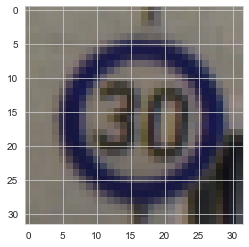

6914 train samples
1729 test samples


In [43]:
# Normalize the data
data = data / 255.0

# now my data is reshaped_data, and the label is data_label
# i want to split the data into train and test, ratio is 0.2
# split the data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, data_label, test_size=0.2, random_state=42)

# print the first picture of X_train
plt.imshow(X_train[0])
plt.show()
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Flatten the images for the Fully-Connected Networks
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [44]:
# Create the network
input_size = 3072
hidden_size = 64
output_size = 3072

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

# print the structure of the model
print(autoencoder.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense_8 (Dense)             (None, 64)                196672    
                                                                 
 dense_9 (Dense)             (None, 3072)              199680    
                                                                 
Total params: 396,352
Trainable params: 396,352
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
55/55 [==============================] - 1s 10ms/step - loss: 0.0822 - val_loss: 0.0686
Epoch 2/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0648 - val_loss: 0.0572
Epoch 3/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0546 - val_loss: 0.0500
Epoch 4/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0480 - val_loss: 0.0472
Epoch 5/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0427 - val_loss: 0.0413
Epoch 6/50
55/55 [==============================] - 0s 9ms/step - loss: 0.0385 - val_loss: 0.0370
Epoch 7/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0352 - val_loss: 0.0328
Epoch 8/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0300 - val_loss: 0.0354
Epoch 9/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0274 - val_loss: 0.0303
Epoch 10/50
55/55 [==============================] - 0s 8ms/step - loss: 0.0253 - val_loss: 0.0244
Epoch 11/50
55/55 

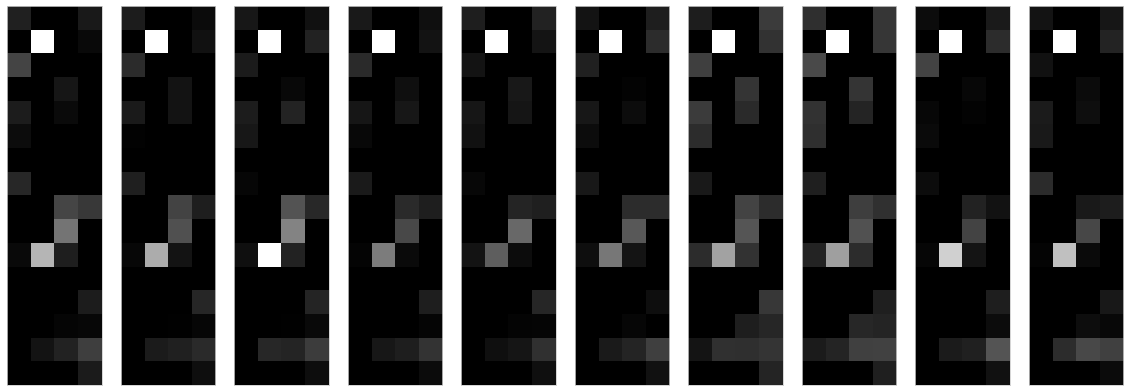

In [45]:
# Train the model
epochs = 50
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1,
                          validation_data=(X_test, X_test))

conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

# show encoded images
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


55/55 [==============================] - 0s 4ms/step


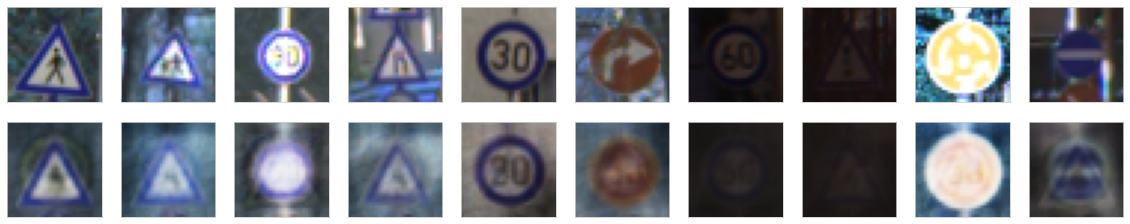

dict_keys(['loss', 'val_loss'])


In [46]:
# Predict on the test set
decoded_imgs = autoencoder.predict(X_test)

# Plot
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

print(history.history.keys())

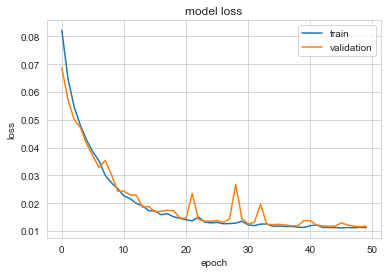

In [47]:
# Plot the losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

271/271 [==============================] - 1s 3ms/step


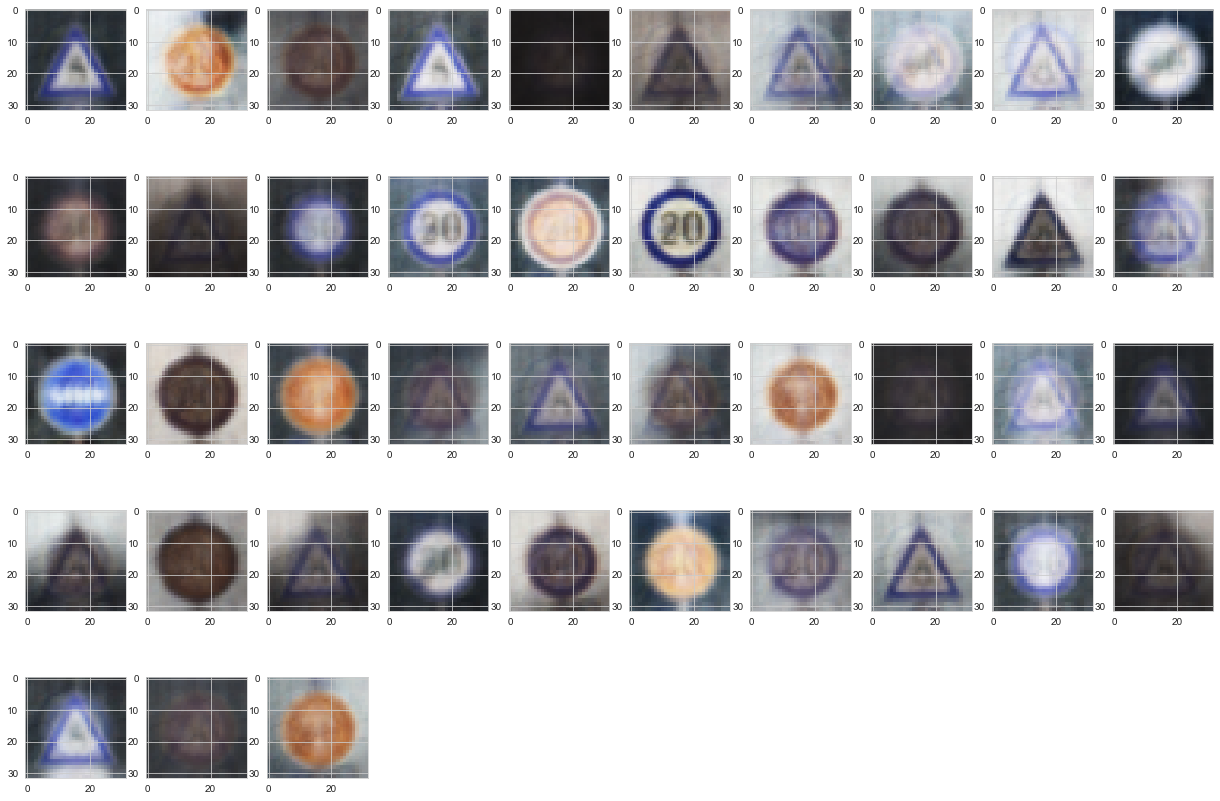

In [53]:
all_data = np.concatenate((X_train, X_test), axis=0)
all_data_features = autoencoder.predict(all_data)
# apply kmeans to get the clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=43, random_state=0).fit(all_data_features)
# This is how our centroids look like
import matplotlib.pyplot as plt
dist_cols = 10
dist_rows = 7
bottom = 0.35
plt.figure(figsize=(3 * dist_cols, 3 * dist_rows))
for i in range(43):
    plt.subplots_adjust(bottom)
    plt.subplot(dist_rows, dist_cols, i+1)
    plt.imshow(kmeans.cluster_centers_[i].reshape(32,32,3))
plt.show()